In [11]:
# Imports

import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from transformers import BertTokenizerFast, BertModel
from torch.utils.data import Dataset, DataLoader
from collections import Counter
from tqdm import tqdm


In [2]:
# General settings
MAX_LENGTH = 256
STRIDE     = 128
BATCH_SIZE = 8
EPOCHS     = 3

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device: ", device)

Using device:  cuda


In [5]:
# Data
train_df = pd.read_csv("train_df.csv")
test_df = pd.read_csv("test_df.csv")

non_audio = ["playlist_genre", "lyrics", "language_en"]
AUDIO_FEATURES = [
    c for c in train_df.select_dtypes(include=[np.number]).columns if c not in non_audio
]

train_df[AUDIO_FEATURES] = train_df[AUDIO_FEATURES].apply(pd.to_numeric, errors="coerce")
test_df[AUDIO_FEATURES] = test_df[AUDIO_FEATURES].apply(pd.to_numeric, errors="coerce")

le = LabelEncoder()
train_df["label"] = le.fit_transform(train_df.playlist_genre)
test_df = test_df[test_df.playlist_genre.isin(le.classes_)].copy()
test_df["label"] = le.transform(test_df.playlist_genre)
num_labels = len(le.classes_)

scaler = StandardScaler().fit(train_df[AUDIO_FEATURES])

In [6]:
# Using BERT Tokenizer
tokenizer = BertTokenizerFast.from_pretrained("bert-base-uncased")

# Chunking the lyrics to capture the whole song
def chunk_lyrics(lyrics):
    enc = tokenizer(
        lyrics,
        return_overflowing_tokens=True,
        truncation=True,
        padding="max_length",
        max_length=MAX_LENGTH,
        stride=STRIDE,
        return_attention_mask=True,
        return_tensors="pt"
    )
    return [(enc.input_ids[i], enc.attention_mask[i]) for i in range(enc.input_ids.size(0))]

In [7]:
# BERT-Only
class BERTTextClassifier(nn.Module):
    def __init__(self, num_labels):
        super().__init__()
        self.bert = BertModel.from_pretrained("bert-base-uncased")
        self.classifier = nn.Linear(self.bert.config.hidden_size, num_labels)

    def forward(self, input_ids, attention_mask):
        out = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        return self.classifier(out.last_hidden_state[:, 0, :])

class LyricsChunkDataset(Dataset):
    def __init__(self, df):
        self.data = []
        for _, row in df.iterrows():
            chunks = chunk_lyrics(row.lyrics)
            for ids, mask in chunks:
                self.data.append((ids, mask, row.label))

    def __len__(self): return len(self.data)
    def __getitem__(self, idx):
        ids, mask, label = self.data[idx]
        return {"input_ids": ids, "attention_mask": mask, "label": torch.tensor(label)}

bert_only_model = BERTTextClassifier(num_labels).to(device)
optimizer = torch.optim.AdamW(bert_only_model.parameters(), lr=2e-5)
criterion = nn.CrossEntropyLoss()

train_loader = DataLoader(LyricsChunkDataset(train_df), batch_size=BATCH_SIZE, shuffle=True)
for epoch in range(EPOCHS):
    bert_only_model.train()
    running_loss = 0
    for batch in tqdm(train_loader, desc=f"[BERT-Only] Epoch {epoch+1}/{EPOCHS}"):
        ids = batch["input_ids"].to(device)
        mask = batch["attention_mask"].to(device)
        lbls = batch["label"].to(device)
        optimizer.zero_grad()
        loss = criterion(bert_only_model(ids, mask), lbls)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    avg_loss = running_loss / len(train_loader)
    print(f"[BERT-Only] Epoch {epoch+1}/{EPOCHS} - Train Loss: {avg_loss:.4f}")

def predict_bert_only(lyrics):
    bert_only_model.eval()
    chunks = chunk_lyrics(lyrics)
    votes = []
    with torch.no_grad():
        for ids, mask in chunks:
            ids = ids.unsqueeze(0).to(device)
            mask = mask.unsqueeze(0).to(device)
            out = bert_only_model(ids, mask)
            votes.append(int(torch.argmax(out)))
    return Counter(votes).most_common(1)[0][0]

bert_only_results = {
    "y_true": test_df.label.tolist(),
    "y_pred": [predict_bert_only(text) for text in test_df.lyrics]
}

bert_only_results["report"] = classification_report(bert_only_results["y_true"], bert_only_results["y_pred"], target_names=le.classes_, output_dict=True)
bert_only_results["confusion_matrix"] = confusion_matrix(bert_only_results["y_true"], bert_only_results["y_pred"])

[BERT-Only] Epoch 1/3: 100%|███████████████████████████████████████████████████████| 7486/7486 [36:06<00:00,  3.46it/s]


[BERT-Only] Epoch 1/3 - Train Loss: 0.8712


[BERT-Only] Epoch 2/3: 100%|███████████████████████████████████████████████████████| 7486/7486 [37:41<00:00,  3.31it/s]


[BERT-Only] Epoch 2/3 - Train Loss: 0.4284


[BERT-Only] Epoch 3/3: 100%|███████████████████████████████████████████████████████| 7486/7486 [39:33<00:00,  3.15it/s]


[BERT-Only] Epoch 3/3 - Train Loss: 0.2576


In [8]:
# BERT + Random Forest

@torch.no_grad()
def get_avg_bert_embedding(model, lyrics):
    model.eval()
    chunks = chunk_lyrics(lyrics)
    return np.mean([
        model.bert(
            input_ids=ids.unsqueeze(0).to(device),
            attention_mask=mask.unsqueeze(0).to(device)
        ).last_hidden_state[:, 0, :].squeeze().cpu().numpy()
        for ids, mask in chunks
    ], axis=0)

bert_rf_model = BERTTextClassifier(num_labels).to(device)
optimizer = torch.optim.AdamW(bert_rf_model.parameters(), lr=2e-5)

rf_train_loader = DataLoader(LyricsChunkDataset(train_df), batch_size=BATCH_SIZE, shuffle=True)
for epoch in range(EPOCHS):
    bert_rf_model.train()
    running_loss = 0
    for batch in tqdm(rf_train_loader, desc=f"[BERT+RF] Epoch {epoch+1}/{EPOCHS}"):
        ids = batch["input_ids"].to(device)
        mask = batch["attention_mask"].to(device)
        lbls = batch["label"].to(device)
        optimizer.zero_grad()
        loss = criterion(bert_rf_model(ids, mask), lbls)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    avg_loss = running_loss / len(rf_train_loader)
    print(f"[BERT+RF] Epoch {epoch+1}/{EPOCHS} - Train Loss: {avg_loss:.4f}")

X_train = np.hstack([
    np.vstack([get_avg_bert_embedding(bert_rf_model, t) for t in train_df.lyrics]),
    scaler.transform(train_df[AUDIO_FEATURES])
])
X_test = np.hstack([
    np.vstack([get_avg_bert_embedding(bert_rf_model, t) for t in test_df.lyrics]),
    scaler.transform(test_df[AUDIO_FEATURES])
])

rf = RandomForestClassifier(n_estimators=200, max_depth=20, class_weight="balanced", random_state=42)
rf.fit(X_train, train_df.label)

rf_preds = rf.predict(X_test)
bert_rf_results = {
    "y_true": test_df.label.tolist(),
    "y_pred": rf_preds.tolist(),
    "report": classification_report(test_df.label, rf_preds, target_names=le.classes_, output_dict=True),
    "confusion_matrix": confusion_matrix(test_df.label, rf_preds)
}

[BERT+RF] Epoch 1/3: 100%|█████████████████████████████████████████████████████████| 7486/7486 [39:40<00:00,  3.14it/s]


[BERT+RF] Epoch 1/3 - Train Loss: 0.8677


[BERT+RF] Epoch 2/3: 100%|█████████████████████████████████████████████████████████| 7486/7486 [39:20<00:00,  3.17it/s]


[BERT+RF] Epoch 2/3 - Train Loss: 0.4220


[BERT+RF] Epoch 3/3: 100%|█████████████████████████████████████████████████████████| 7486/7486 [39:06<00:00,  3.19it/s]


[BERT+RF] Epoch 3/3 - Train Loss: 0.2535


In [9]:
# BERT + MLP
class BERTWithAudioMLP(nn.Module):
    def __init__(self, audio_dim, num_labels):
        super().__init__()
        self.bert = BertModel.from_pretrained("bert-base-uncased")
        self.audio_proj = nn.Sequential(
            nn.Linear(audio_dim, 128), nn.BatchNorm1d(128), nn.ReLU(), nn.Dropout(0.2),
            nn.Linear(128, 64), nn.BatchNorm1d(64), nn.ReLU()
        )
        self.classifier = nn.Sequential(
            nn.Linear(self.bert.config.hidden_size + 64, 128),
            nn.ReLU(), nn.Dropout(0.3),
            nn.Linear(128, num_labels)
        )

    def forward(self, input_ids, attention_mask, audio_feats):
        cls = self.bert(input_ids=input_ids, attention_mask=attention_mask).last_hidden_state[:, 0, :]
        audio_emb = self.audio_proj(audio_feats)
        return self.classifier(torch.cat([cls, audio_emb], dim=1))

mlp_model = BERTWithAudioMLP(len(AUDIO_FEATURES), num_labels).to(device)
mlp_optimizer = torch.optim.AdamW(mlp_model.parameters(), lr=2e-5)

from sklearn.utils.class_weight import compute_class_weight
weights = compute_class_weight("balanced", classes=np.unique(train_df.label), y=train_df.label)
mlp_criterion = nn.CrossEntropyLoss(weight=torch.tensor(weights, dtype=torch.float32).to(device))

class MultimodalDataset(Dataset):
    def __init__(self, df):
        self.lyrics = df.lyrics.tolist()
        self.audio = scaler.transform(df[AUDIO_FEATURES])
        self.labels = df.label.tolist()

    def __len__(self): return len(self.lyrics)
    def __getitem__(self, idx):
        tokens = tokenizer(self.lyrics[idx], truncation=True, padding="max_length", max_length=MAX_LENGTH, return_tensors="pt")
        return {
            "input_ids": tokens.input_ids.squeeze(),
            "attention_mask": tokens.attention_mask.squeeze(),
            "audio_feats": torch.tensor(self.audio[idx], dtype=torch.float32),
            "label": torch.tensor(self.labels[idx])
        }

train_loader = DataLoader(MultimodalDataset(train_df), batch_size=BATCH_SIZE, shuffle=True)
for epoch in range(EPOCHS):
    mlp_model.train()
    running_loss = 0
    for batch in tqdm(train_loader, desc=f"[BERT+MLP] Epoch {epoch+1}/{EPOCHS}"):
        ids = batch["input_ids"].to(device)
        mask = batch["attention_mask"].to(device)
        audio = batch["audio_feats"].to(device)
        lbls = batch["label"].to(device)
        mlp_optimizer.zero_grad()
        loss = mlp_criterion(mlp_model(ids, mask, audio), lbls)
        loss.backward()
        mlp_optimizer.step()
        running_loss += loss.item()
    avg_loss = running_loss / len(train_loader)
    mlp_model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for _, row in test_df.iterrows():
            chunks = chunk_lyrics(row.lyrics)
            audio_vec = torch.tensor(scaler.transform([row[AUDIO_FEATURES]]), dtype=torch.float32).to(device)
            preds = []
            for ids, mask in chunks:
                ids = ids.unsqueeze(0).to(device)
                mask = mask.unsqueeze(0).to(device)
                out = mlp_model(ids, mask, audio_vec)
                preds.append(int(out.argmax(1)))
            prediction = max(set(preds), key=preds.count)
            correct += int(prediction == row.label)
            total += 1
    val_acc = correct / total
    print(f"[BERT+MLP] Epoch {epoch+1}/{EPOCHS} - Train Loss: {avg_loss:.4f}, Val Acc: {val_acc:.2%}")

mlp_model.eval()
mlp_results = {"y_true": [], "y_pred": []}
with torch.no_grad():
    for _, row in test_df.iterrows():
        chunks = chunk_lyrics(row.lyrics)
        audio_vec = torch.tensor(scaler.transform([row[AUDIO_FEATURES]]), dtype=torch.float32).to(device)
        preds = []
        for ids, mask in chunks:
            ids = ids.unsqueeze(0).to(device)
            mask = mask.unsqueeze(0).to(device)
            out = mlp_model(ids, mask, audio_vec)
            preds.append(int(out.argmax(1)))
        mlp_results["y_true"].append(int(row.label))
        mlp_results["y_pred"].append(max(set(preds), key=preds.count))

mlp_results["report"] = classification_report(mlp_results["y_true"], mlp_results["y_pred"], target_names=le.classes_, output_dict=True)
mlp_results["confusion_matrix"] = confusion_matrix(mlp_results["y_true"], mlp_results["y_pred"])


[BERT+MLP] Epoch 1/3: 100%|████████████████████████████████████████████████████████| 1669/1669 [08:52<00:00,  3.13it/s]


[BERT+MLP] Epoch 1/3 - Train Loss: 1.3166, Val Acc: 57.02%


[BERT+MLP] Epoch 2/3: 100%|████████████████████████████████████████████████████████| 1669/1669 [08:59<00:00,  3.09it/s]


[BERT+MLP] Epoch 2/3 - Train Loss: 1.0494, Val Acc: 59.42%


[BERT+MLP] Epoch 3/3: 100%|████████████████████████████████████████████████████████| 1669/1669 [08:55<00:00,  3.12it/s]


[BERT+MLP] Epoch 3/3 - Train Loss: 0.8209, Val Acc: 57.21%


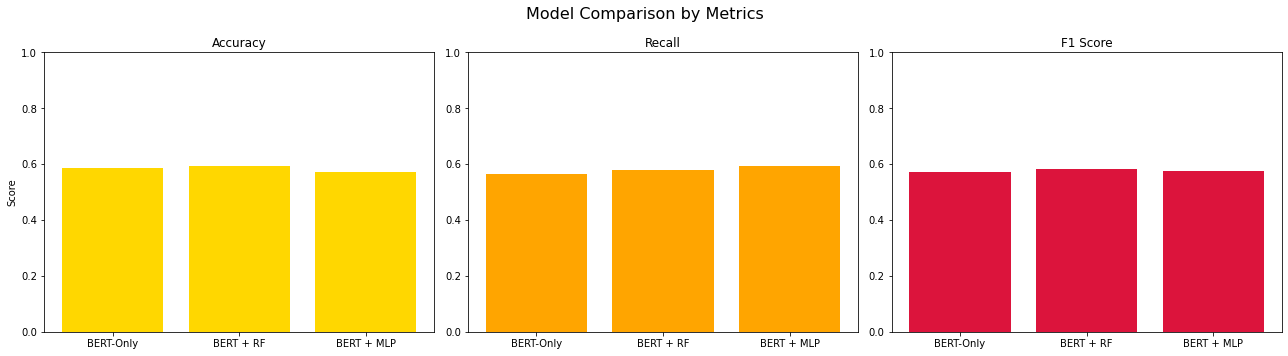

In [12]:
# Bar Chart for accuracy, recall and F1 score
actual_results = {
    "bert_only": {
        "accuracy": bert_only_results["report"]["accuracy"],
        "recall": bert_only_results["report"]["macro avg"]["recall"],
        "f1": bert_only_results["report"]["macro avg"]["f1-score"]
    },
    "bert_rf": {
        "accuracy": bert_rf_results["report"]["accuracy"],
        "recall": bert_rf_results["report"]["macro avg"]["recall"],
        "f1": bert_rf_results["report"]["macro avg"]["f1-score"]
    },
    "bert_mlp": {
        "accuracy": mlp_results["report"]["accuracy"],
        "recall": mlp_results["report"]["macro avg"]["recall"],
        "f1": mlp_results["report"]["macro avg"]["f1-score"]
    }
}

# Bar chart
fig, axs = plt.subplots(1, 3, figsize=(18, 5))
model_names = ['BERT-Only', 'BERT + RF', 'BERT + MLP']

# Plot
axs[0].bar(model_names, [actual_results[m]["accuracy"] for m in actual_results], color='gold')
axs[0].set_title('Accuracy')
axs[0].set_ylim(0, 1)
axs[0].set_ylabel('Score')

axs[1].bar(model_names, [actual_results[m]["recall"] for m in actual_results], color='orange')
axs[1].set_title('Recall')
axs[1].set_ylim(0, 1)

axs[2].bar(model_names, [actual_results[m]["f1"] for m in actual_results], color='crimson')
axs[2].set_title('F1 Score')
axs[2].set_ylim(0, 1)

plt.suptitle('Model Comparison by Metrics', fontsize=16)
plt.tight_layout()
plt.show()


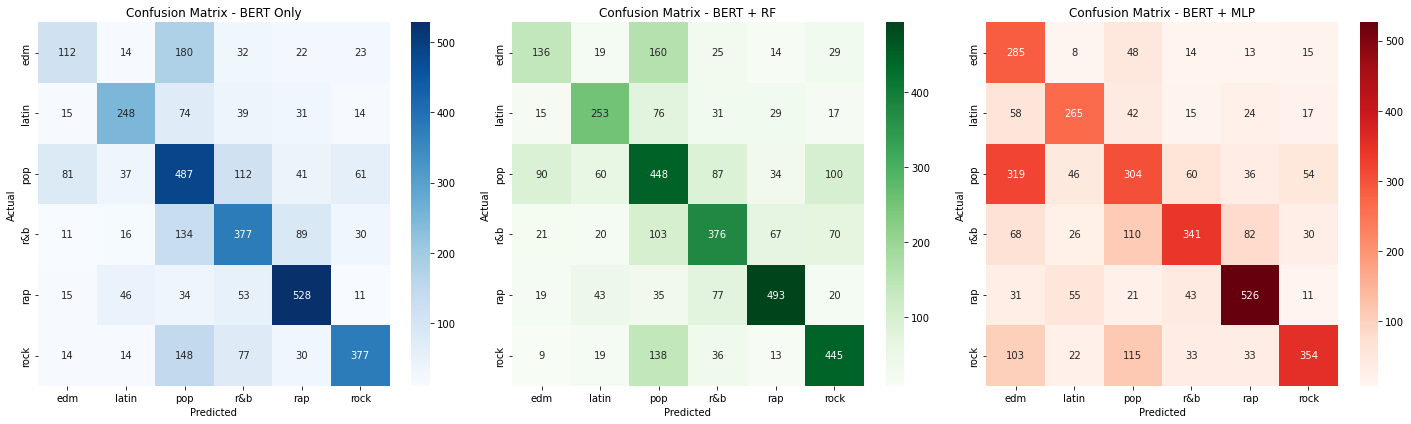

In [13]:
# Confusion Matrix
bert_only_cm = bert_only_results["confusion_matrix"]
bert_rf_cm = bert_rf_results["confusion_matrix"]
mlp_cm = mlp_results["confusion_matrix"]

genre_labels = ["edm", "latin", "pop", "r&b", "rap", "rock"]

fig, axes = plt.subplots(1, 3, figsize=(20, 6))

sns.heatmap(bert_only_cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=genre_labels, yticklabels=genre_labels, ax=axes[0])
axes[0].set_title("Confusion Matrix - BERT Only")
axes[0].set_xlabel("Predicted")
axes[0].set_ylabel("Actual")

sns.heatmap(bert_rf_cm, annot=True, fmt='d', cmap='Greens',
            xticklabels=genre_labels, yticklabels=genre_labels, ax=axes[1])
axes[1].set_title("Confusion Matrix - BERT + RF")
axes[1].set_xlabel("Predicted")
axes[1].set_ylabel("Actual")

sns.heatmap(mlp_cm, annot=True, fmt='d', cmap='Reds',
            xticklabels=genre_labels, yticklabels=genre_labels, ax=axes[2])
axes[2].set_title("Confusion Matrix - BERT + MLP")
axes[2].set_xlabel("Predicted")
axes[2].set_ylabel("Actual")

plt.tight_layout()
plt.show()


In [14]:
# Classification Report

print("Classification Report: BERT-Only")
print(classification_report(bert_only_results["y_true"], bert_only_results["y_pred"], target_names=le.classes_))

print("Classification Report: BERT + Random Forest")
print(classification_report(bert_rf_results["y_true"], bert_rf_results["y_pred"], target_names=le.classes_))

print("Classification Report: BERT + MLP")
print(classification_report(mlp_results["y_true"], mlp_results["y_pred"], target_names=le.classes_))


Classification Report: BERT-Only
              precision    recall  f1-score   support

         edm       0.45      0.29      0.35       383
       latin       0.66      0.59      0.62       421
         pop       0.46      0.59      0.52       819
         r&b       0.55      0.57      0.56       657
         rap       0.71      0.77      0.74       687
        rock       0.73      0.57      0.64       660

    accuracy                           0.59      3627
   macro avg       0.59      0.56      0.57      3627
weighted avg       0.60      0.59      0.59      3627

Classification Report: BERT + Random Forest
              precision    recall  f1-score   support

         edm       0.47      0.36      0.40       383
       latin       0.61      0.60      0.61       421
         pop       0.47      0.55      0.50       819
         r&b       0.59      0.57      0.58       657
         rap       0.76      0.72      0.74       687
        rock       0.65      0.67      0.66       660



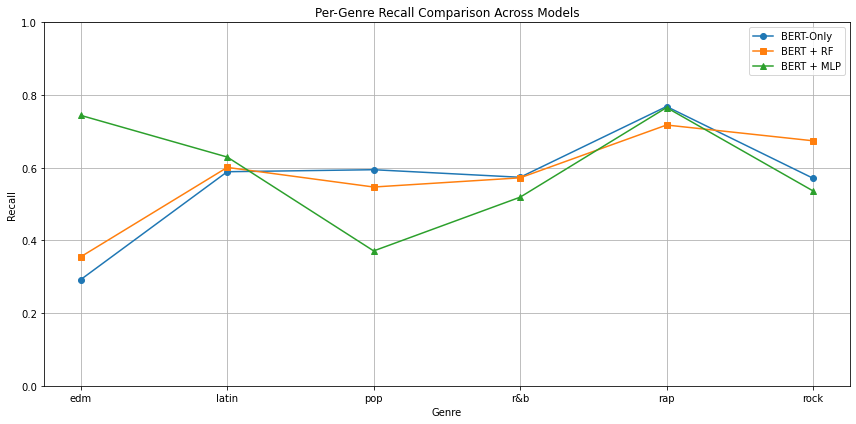

In [15]:
# Per genre comparison
genre_labels = ["edm", "latin", "pop", "r&b", "rap", "rock"]

bert_only_recall = [bert_only_results["report"][g]["recall"] for g in genre_labels]
bert_rf_recall = [bert_rf_results["report"][g]["recall"] for g in genre_labels]
mlp_recall = [mlp_results["report"][g]["recall"] for g in genre_labels]

# Plot line chart
plt.figure(figsize=(12, 6))
plt.plot(genre_labels, bert_only_recall, marker='o', label='BERT-Only')
plt.plot(genre_labels, bert_rf_recall, marker='s', label='BERT + RF')
plt.plot(genre_labels, mlp_recall, marker='^', label='BERT + MLP')

plt.title("Per-Genre Recall Comparison Across Models")
plt.xlabel("Genre")
plt.ylabel("Recall")
plt.ylim(0, 1)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [18]:
# Model Parameters

print("Number of parameters for BERT-Only: ", sum(p.numel() for p in bert_only_model.parameters() if p.requires_grad))
print("Number of parameters for BERT + Random Forest: ", sum(p.numel() for p in bert_rf_model.parameters() if p.requires_grad))
print("Number of parameters for BERT + MLP: ", sum(p.numel() for p in mlp_model.parameters() if p.requires_grad))

Number of parameters for BERT-Only:  109486854
Number of parameters for BERT + Random Forest:  109486854
Number of parameters for BERT + MLP:  109599174
